## **1. Problem Definition**

###  **Understanding Key Cricket Concepts**

- **Over**: An *over* in cricket consists of 6 consecutive legal deliveries (balls) bowled by the same bowler. In One Day Internationals (ODIs), each team plays a maximum of 50 overs.

- **Run Rate**: Run rate is the average number of runs scored per ball. It is calculated as:  
  \[
  \text{Run Rate} = \frac{\text{Total Runs Scored}}{\text{Total Balls Faced}}
  \]

- **Batting Lineup**: The batting lineup determines the sequence in which players go out to bat. The order can influence the total score, depending on a player's performance at a particular position.

- **Key Factors Influencing Match Outcomes**:
  - **Location of the Match**: Conditions like pitch type, weather, and crowd support vary by location and can affect player performance.
  - **Batting Lineup Strategy**: Teams strategically decide batting positions based on form, matchups, and past performance in similar conditions.
  - **Opponent Team and Bowlers**: The opposing team's bowling strength influences how well a batsman performs.
  - *(Note: For this project, only Location and Batting Lineup are considered as variables.)*


### **Problem Statement**

In this project, I aim to determine the **optimal batting lineup based on match location** for three top Indian batsmen:

- **KL Rahul**
- **Virat Kohli**
- **Rishabh Pant**

I consider two distinct match locations:

- **India**
- **England**

The goal is to use past performance data (since 2015) to **simulate match outcomes** and identify the batting order that **maximizes the total expected score** of these three players for a given location. 

To ensure realism and fairness in the lineup selection, I introduce the following key constraint:

- Each selected player's **expected run rate must be greater than 0.6** in the assigned batting position for that location.


## **2.Formulation**

### **Dataset Description**  
The dataset used in this project contains past performance statistics of three Indian cricket players — **KL Rahul, Virat Kohli, and Rishabh Pant** — from matches played in **India and England**. The dataset was sourced from [Cricmetric](https://www.cricmetric.com/index.py), and contains the following columns:

| Column            | Description                                         |
|------------------|-----------------------------------------------------|
| Player_Name       | Name of the batsman                                 |
| Match             | Match identifier                                    |
| Run               | Runs scored in the match                            |
| Balls             | Number of balls faced                               |
| Batting_Position  | Batting position in the lineup (e.g., 1 to 11)      |
| Location          | Location of the match (India or England)            |
| Av_R.R            | Run Rate (Runs ÷ Balls) for that match              |

###  **Key Variables**  
In this project, the key variables are:
- **Player_Name**: The batsman under consideration.
- **Location**: Stadium location (India or England).
- **Batting_Position**: The position in the batting order (e.g., 1st, 2nd...).
- **Run** and **Balls**: Used to evaluate batting performance.
- **Run Rate (Av_R.R)**: Essential because matches are limited to a fixed number of overs.

Since **One Day Internationals (ODIs)** are limited to 50 overs per team (i.e., 300 balls), I must not only **maximize total score** but also ensure **good scoring efficiency (run rate)**. That’s why both **score** and **balls faced** are considered critical.


### **Subgrouping Strategy for Simulation**  
To estimate expected performance, the dataset is grouped into **subgroups based on**:
- Player_Name  
- Location  
- Batting_Position  

Each subgroup contains records with the **same player, location, and batting position**.  
The goal of the simulation is to estimate the:
- **Expected total runs**
- **Expected run rate**  
for each player at each eligible batting position in both locations.


### **Simulation Constraints**  
In the simulation, both **Runs** and **Balls** are simulated jointly to preserve their relationship.  
To ensure realism, these constraints are enforced:
- **Runs cannot be negative**
- **Each player must play at least one ball**
- **Maximum runs scored cannot exceed 6 × Balls faced**

To simulate 1000 realistic combinations of scores and balls while maintaining their relationship, I use **Kernel Density Estimation (KDE)**. This method is explained in the next part of the report and is chosen for its ability to generate realistic, continuous data based on original performance.



### **Simplex Method and Constraints**  
Once expected scores and run rates are generated for each player-batting position-location combination, the next step is to **determine the optimal batting lineup** using the **Simplex Method**.

The following **constraints** are enforced in this linear programming step:
-  **One player can have only one batting position**
-  **Each batting position can be taken by only one player**
-  **Run rate must be ≥ 0.6** for a position to be considered valid  
-  **Player-specific position eligibility**, e.g.,  
   - *KL Rahul can only play positions 2, 4, and 5 in India*

### **Optimization Objective**  
The objective function is to:

- **Maximize the total expected score of the 3 selected players**  
- Based on the stadium location and valid constraints.




## **3.Data**

### **Data Collection**

The player performance data for this project was collected from the website: [https://www.cricmetric.com/index.py](https://www.cricmetric.com/index.py).  
For each of the three selected Indian players — **KL Rahul, Virat Kohli, and Rishabh Pant** — the data was queried using the following parameters:

- **Batting Format:** One Day Internationals (ODIs)  
- **Venue Countries:** India and England  
- **Batting Positions:** 1 to 7  
- **Time Period:** From 2015 onwards  
- **Grouping Option on Website:** *Group by Match*

Each query returned match-wise batting statistics for the selected player under the specified conditions. After downloading the results as Excel files, I merged all player-specific datasets into a **main combined dataset**.

### **Data Structure**

The final dataset includes the following columns:

| Column Name        | Description                                          |
|--------------------|------------------------------------------------------|
| Player_Name        | Name of the batsman                                  |
| Match              | Unique match identifier                              |
| Run                | Runs scored in that match                            |
| Balls              | Balls faced in that match                            |
| Batting_Position   | The player’s batting position in that match          |
| Location           | Venue country (India or England)                     |
| Av_R.R             | Average Run Rate (Run ÷ Balls) for that match        |


### Import all the required libraries

In [86]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
from gurobipy import Model, GRB


### Load the required data set 
You do need to chnage the file path to load the data set. I will also rename couple of columns for better undersatanding.

### Dataset Column Descriptions

- **Player_Name**  :The name of the Indian men's cricket team player. 
- **Match**        :The unique identifier or description of the match in which the player batted (e.g., opponent, date, or match number). 
- **Run**          : The number of runs scored by the player in that particular match. 
- **Balls**         : The number of balls the player faced during the match. 
- **Batting_Position** : The position at which the player came to bat in the batting order (e.g., 1 for opener, 4 for middle-order, etc.). 
- **Location**         :The country where the match was played (In our case its just, India, England). 
- **Av_R.R**           : The average run rate (Runs per 6 Ball) for that particular performance, calculated as `Run / (Balls/6)`. 


In [87]:
df = pd.read_excel("Data_612_project.xlsx", engine='openpyxl') 

# Renmaing the columns
df = df.rename(columns={'Batting Position': 'Batting_Position'})
df = df.rename(columns={'Average': 'Av_R.R'})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Player_Name       165 non-null    object 
 1   Match             165 non-null    object 
 2   Run               165 non-null    int64  
 3   Balls             165 non-null    int64  
 4   Batting_Position  165 non-null    int64  
 5   Location          165 non-null    object 
 6   Av_R.R            165 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 9.2+ KB


#### **Data Grouping**
The dataset is first grouped by the following three columns:
- Player_Name
- Location
- Batting_Position

I am group the data set of player's performance as it can vary significantly depending on who they are, where they're playing (location), and which batting position they are assigned. These three factors most strongly influence batting outcomes and help create more accurate simulations.

After this i will generate 1000 simulations for each of these groups based on the combined probibity distrution of **Run and Balls** they played.

In [88]:

grouped = df.groupby(['Player_Name', 'Location', 'Batting_Position'])

# print the Dataframes or sungroups
for (player, location, batting_pos), group_df in grouped:
    print(f"\nGroup: Player={player}, Location={location}, Batting Position={batting_pos}")
    print(group_df)  
    print("-" * 50) 


Group: Player=KL Rahul, Location=England, Batting Position=1
   Player_Name    Match   Run  Balls  Batting_Position Location    Av_R.R
30    KL Rahul  2019_101   57     78                 1  England  4.384615
31    KL Rahul  2019_107   30     53                 1  England  3.396226
32    KL Rahul  2019_113   48     64                 1  England  4.500000
33    KL Rahul  2019_117    0      9                 1  England  0.000000
34    KL Rahul  2019_119   77     92                 1  England  5.021739
35    KL Rahul  2019_123  111    118                 1  England  5.644068
36    KL Rahul  2019_125    1      7                 1  England  0.857143
--------------------------------------------------

Group: Player=KL Rahul, Location=England, Batting Position=4
   Player_Name    Match   Run  Balls  Batting_Position Location     Av_R.R
37    KL Rahul  2018_007    9     18                 4  England   3.000000
38    KL Rahul  2018_008    0      2                 4  England   0.000000
39    KL

In [89]:
# List all key combinations of these groups
print(list(grouped.groups.keys()))

[('KL Rahul', 'England', 1), ('KL Rahul', 'England', 4), ('KL Rahul', 'India', 2), ('KL Rahul', 'India', 4), ('KL Rahul', 'India', 5), ('Rishabh Pant', 'England', 4), ('Rishabh Pant', 'India', 4), ('Rishabh Pant', 'India', 5), ('Virat Kohli', 'England', 3), ('Virat Kohli', 'England', 4), ('Virat Kohli', 'India', 3), ('Virat Kohli', 'India', 4)]


**Note: Each group in grouped data set has a unique combination of Player Name , Location and batting lineup Position.** This makes the data ready to apply the simualtions.

 




## **4.Anaylsis**

### Project Objective: Optimizing Batting Lineups Based on Location and Position

In this project, My goal is to determine the **best possible batting lineup for three selected Indian men's cricket players**, based on their past performance data. The key idea is to use **simulation techniques** to estimate expected performance under different conditions and optimize batting lineup choices accordingly.

#### Key points of the data set.

- **Players Selected:** Indian Men’s Cricket Team players (KL Rahul, Virat Kohli , Rishabh Pant).
- **Timeframe:** Matches from **March 2015 to Present**.
- **Locations Considered:** Only matches played in **India** and **England** are included.
- **Batting Positions:** Various batting positions (e.g., 1, 2, 3, etc.) are considered for each player based on their historical records.
- **Metrics Analyzed:**
  - Total Runs Scored
  - Balls Faced
  - Derived Run Rate (Runs per Ball) .  


### Simulation Strategy

To model realistic future performance:

 **Simulations:**  
   For each group, I simulate **1,000 possible innings** using a **kernel density estimation (KDE)** approach. This accounts for the relationship between `Runs` and `Balls Faced`, preserving their correlation.

 **Objective:**  
   From these simulations, I calculate:
   - Expected Runs
   - Expected Run Rate  
   
   These metrics are then used to select the **optimal batting order** for a match played in a specific location, aiming to **maximize total runs** while ensuring that **no two players are assigned to the same batting position**.

Ok! Now.

#### Before Applying the Simulation

In this project, I’m simulating two variables: `Run` and `Balls`. These variables are **correlated**, scoring more runs means facing more balls. However, this relationship isn’t always linear and can vary between players and location of the match. So, it's important to simulate them together, **preserving their dependencies**.

To achieve this, I’m using **Kernel Density Estimation (KDE)**, which allows me to model and generate realistic pairs of `Run` and `Balls` that reflect how they behave in the actual data. I learned this concept in Data 613.  

#### What is **Kernel Density Estimation (KDE)** and Why Use It?

**KDE** is a non-parametric method to estimate the distribution of a variable. It works by placing a smooth curve (like a Gaussian in my case) on each data point and summing them to form a continuous distribution.

In this case, KDE helps estimate the **joint distribution** of `Run` and `Balls`, so I can generate new, realistic data points that reflect how these two variables relate. This is especially useful when some groups in my data are small,i cannot apply the fit function to see distribution, but KDE naturally do this based on the 2D data distrubtion of `Run` and `Balls`.

### Constarints on the simualtion:
- The Runs value cannot be negitive.
- The minmum number of balls a player played should be atlest 1. 

#### Derived RUN Rate or `sim_av_rr` . 
- I am derving another varible which is Run rate. It the ratio betten runs made by a player in a match and total balls he played. 
**Note, this is NOT the run rate mosthly used in the cricket stats BUT THE idea is the same.**.


**In the below code i am just applying this on a specific sub-group to give an idea what KDE do.**

In [90]:
# original group data
group_key = ('KL Rahul', 'India', 5)
group_df = grouped.get_group(group_key)

# Converting the two 1D arrays into a 2D matrix with shape (2, N) , where columns are RUN and Balls
data = np.vstack([group_df['Run'], group_df['Balls']])

# Fit 2D KDE 
kde = gaussian_kde(data)  

#  Generate 1000 simulations
sim_runs, sim_balls = kde.resample(size=1000)

# Constarints
sim_runs = np.clip(sim_runs, 0, None)       # no negative runs
sim_balls = np.clip(sim_balls, 1, None)     # minimum 1 ball faced
sim_av_rr = sim_runs / sim_balls             # Derived metric




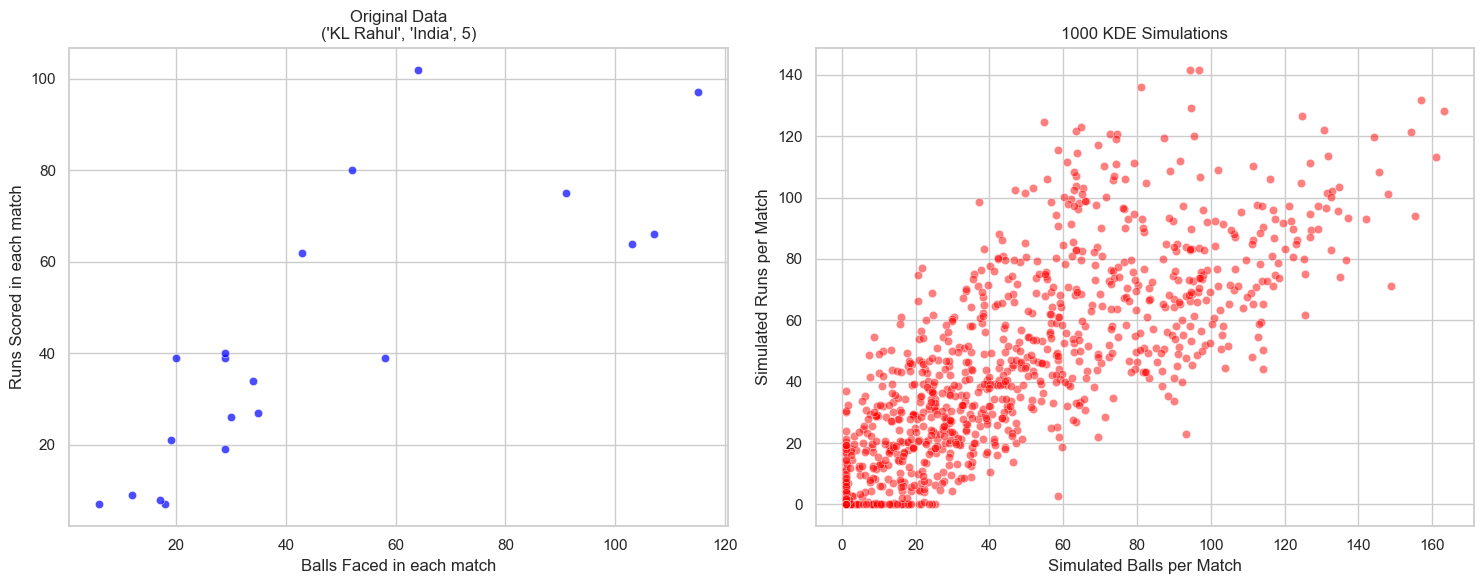

Mean Runs:  43.0 (Original)  vs  44.3 (Simulated)
Mean Balls: 45.5 (Original)  vs  46.7 (Simulated)
Correlation: 0.81 (Original)  vs  0.78 (Simulated)


In [91]:
# Create comparison plots
plt.figure(figsize=(15, 6))

# Scater plot of Original Data
plt.subplot(1, 2, 1)
sns.scatterplot(x=group_df['Balls'], y=group_df['Run'], color='blue', alpha=0.7)
plt.title(f"Original Data\n{group_key}")
plt.xlabel("Balls Faced in each match")
plt.ylabel("Runs Scored in each match")
plt.grid(True)

# Scatter plot of simulation data points
plt.subplot(1, 2, 2)
sns.scatterplot(x=sim_balls, y=sim_runs, color='red', alpha=0.5)
plt.title("1000 KDE Simulations")
plt.xlabel("Simulated Balls per Match")
plt.ylabel("Simulated Runs per Match")
plt.grid(True)

plt.tight_layout()
plt.show()


# Statistics Comparison
print(f"Mean Runs:  {group_df['Run'].mean():.1f} (Original)  vs  {sim_runs.mean():.1f} (Simulated)")
print(f"Mean Balls: {group_df['Balls'].mean():.1f} (Original)  vs  {sim_balls.mean():.1f} (Simulated)")
print(f"Correlation: {np.corrcoef(group_df['Run'], group_df['Balls'])[0,1]:.2f} (Original)  vs  {np.corrcoef(sim_runs, sim_balls)[0,1]:.2f} (Simulated)")

#### Comparison between Orginal data points and Simulation data points. 
- The KDE simulation closely replicates the original data’s behavior. The mean values of Runs and Balls are nearly identical between the original and simulated data, and the correlation between them is also preserved (0.81 vs 0.82). 
- Additionally, the scatter plots show the same upward trend and similar distribution of data points, **confirming that KDE successfully captures the joint relationship between Runs and Balls.**

Lets create the simulations for all the Grouped data sets. 


#### Another Constraint for Simulation: `sim_av_rr <= 6`

Another constarint i need is ,`sim_av_rr <= 6`. I applied for two main reasons:

**Realistic Simulations**: In cricket, it's Imposible for a player to have an average run rate greater than 6 runs per ball. This constraint ensures the simulated values reflect realistic player performance.

 **Outlier Removal**: By removing data points where `sim_av_rr > 6`, I prevent extreme outliers that do not represent typical cricket match scenarios.

**Preserving Distribution**: While removing unrealistic outliers, this constraint maintains the overall shape of the data’s probability distribution, ensuring that the simulation remains consistent with the original data’s density.

This approach ensures that the simulations are both realistic and statistically valid.


In [92]:
# for reproducibility
np.random.seed(41)

# to store all simulated DataFrames
simulated_groups = {}

# simulation for each grouped data set and store it in data frame
for group_key, group_df in grouped:
    player, location, batting_pos = group_key
    
    # # Converting the two 1D arrays into a 2D matrix with shape (2, N) , where columns are RUN and Balls
    data = np.vstack([group_df['Run'], group_df['Balls']])
    # Fit 2D KDE
    kde = gaussian_kde(data, bw_method='scott')
    
    # Resample data
    sim_runs, sim_balls = kde.resample(size=1000)
    
    # Apply constraints
    sim_runs = np.clip(sim_runs, 0, None)   # Run should not be negative
    sim_balls = np.clip(sim_balls, 1, None)  # Balls should be at least 1
    
    # Apply the constraint that sim_av_rr <= 6
    valid_sim_runs = []
    valid_sim_balls = []
    
    for i in range(len(sim_runs)):
        sim_rr = sim_runs[i] / sim_balls[i]
        
        # Resample until sim_av_rr <= 6
        while sim_rr > 6:
            sim_runs[i], sim_balls[i] = kde.resample(1)
            sim_rr = sim_runs[i] / sim_balls[i]
        
        # Store valid values
        valid_sim_runs.append(sim_runs[i])
        valid_sim_balls.append(sim_balls[i])
    
    # Creating dataframe for each Grouped data
    simulated_groups[group_key] = pd.DataFrame({
        'Player_Name': player,
        'Location': location,
        'Batting_Position': batting_pos,
        'Run': valid_sim_runs,
        'Balls': valid_sim_balls,
        'sim_av_rr': np.array(valid_sim_runs) / np.array(valid_sim_balls)  
    })


/var/folders/sh/8wmrp9hs5bn4nq4jmq1t_d9r0000gn/T/ipykernel_92872/599931271.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sim_runs[i], sim_balls[i] = kde.resample(1)


In [93]:
# checking a sample group to confirm
simulated_groups[('Virat Kohli', 'India', 3)].describe()


,Batting_Position,Run,Balls,sim_av_rr
count,1000.0,1000.000000,1000.000000,1000.000000
mean,3.0,59.005802,58.427366,0.887102
std,0.0,50.930036,46.284668,0.622066
min,3.0,-14.285004,-22.828203,-0.567008
25%,3.0,12.534922,15.590813,0.685412
50%,3.0,50.408173,52.648012,0.943554
75%,3.0,98.425650,94.571368,1.120125
max,3.0,210.990354,198.767362,5.997252


#### Next Steps: Expected Values for Optimization
- After filtering the data, I will calculate the expected run, expected balls, and the expected run rate (sim_av_rr) for each group. These expected values will represent the average performance of players across **different locations and batting positions.**

- These expected values will be the key variables used in the **simplex method** to optimize the batting lineup. **The goal is to maximize the total runs** while respecting the constraint that each player can only occupy one position in the lineup.

In [94]:
summary_data = []

# Loop through the simulated sub-groups and find expected value of Run and Balls for each group
for key, df in simulated_groups.items():
    player, location, batting_pos = key
    
    expected_run = df['Run'].mean()
    expected_rr = df['sim_av_rr'].mean()
    
    summary_data.append({
        'Player_Name': player,
        'Location': location,
        'Batting_Position': batting_pos,
        'Expected_Run': expected_run,
        'Expected_RR': expected_rr
    })

# Converting to dataframe
simulation_summary_df = pd.DataFrame(summary_data)

# sorting
simulation_summary_df = simulation_summary_df.sort_values(
    by=['Player_Name', 'Location', 'Batting_Position']
).reset_index(drop=True)


In [95]:
simulation_summary_df

,Player_Name,Location,Batting_Position,Expected_Run,Expected_RR
0,KL Rahul,England,1,50.257910,0.611782
1,KL Rahul,England,4,12.824742,0.736363
2,KL Rahul,India,2,49.111232,0.689163
3,KL Rahul,India,4,59.463290,1.006248
4,KL Rahul,India,5,46.253782,1.024319
5,Rishabh Pant,England,4,46.163623,0.811417
6,Rishabh Pant,India,4,30.485436,0.938933
7,Rishabh Pant,India,5,45.945879,1.433688
8,Virat Kohli,England,3,51.885739,0.833646
9,Virat Kohli,England,4,49.089381,0.710002


### Simulation Summary DataFrame: `simulation_summary_df`

The `simulation_summary_df` showcases the **expected performance metrics** (i.e., Expected Runs and Expected Run Rate) for each player across various **batting positions** and **locations**. It reflects the possible batting lineup configurations for each player based on the location of the match.

For example:
- **Virat Kohli**: If the match is held in **India**, he can take **Batting Positions 3 and 4** based on his past performance in those positions, as shown in the data. His expected runs and run rates for these positions are included in the table.
- **Rishabh Pant**: For a match in **England**, he can only take **Batting Position 4**. His expected runs and run rate for this position are provided accordingly.

The DataFrame thus helps in identifying the feasible batting positions each player can take based on the location of the match, making it useful for optimizing the batting lineup.

#### Lets Plot the results:

/var/folders/sh/8wmrp9hs5bn4nq4jmq1t_d9r0000gn/T/ipykernel_92872/1178286394.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=simulation_summary_df, x="Batting_Position", y="Expected_Run", hue="Player_Name", ci=None, ax=ax[0])
/var/folders/sh/8wmrp9hs5bn4nq4jmq1t_d9r0000gn/T/ipykernel_92872/1178286394.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=simulation_summary_df, x="Batting_Position", y="Expected_RR", hue="Player_Name", ci=None, ax=ax[1])


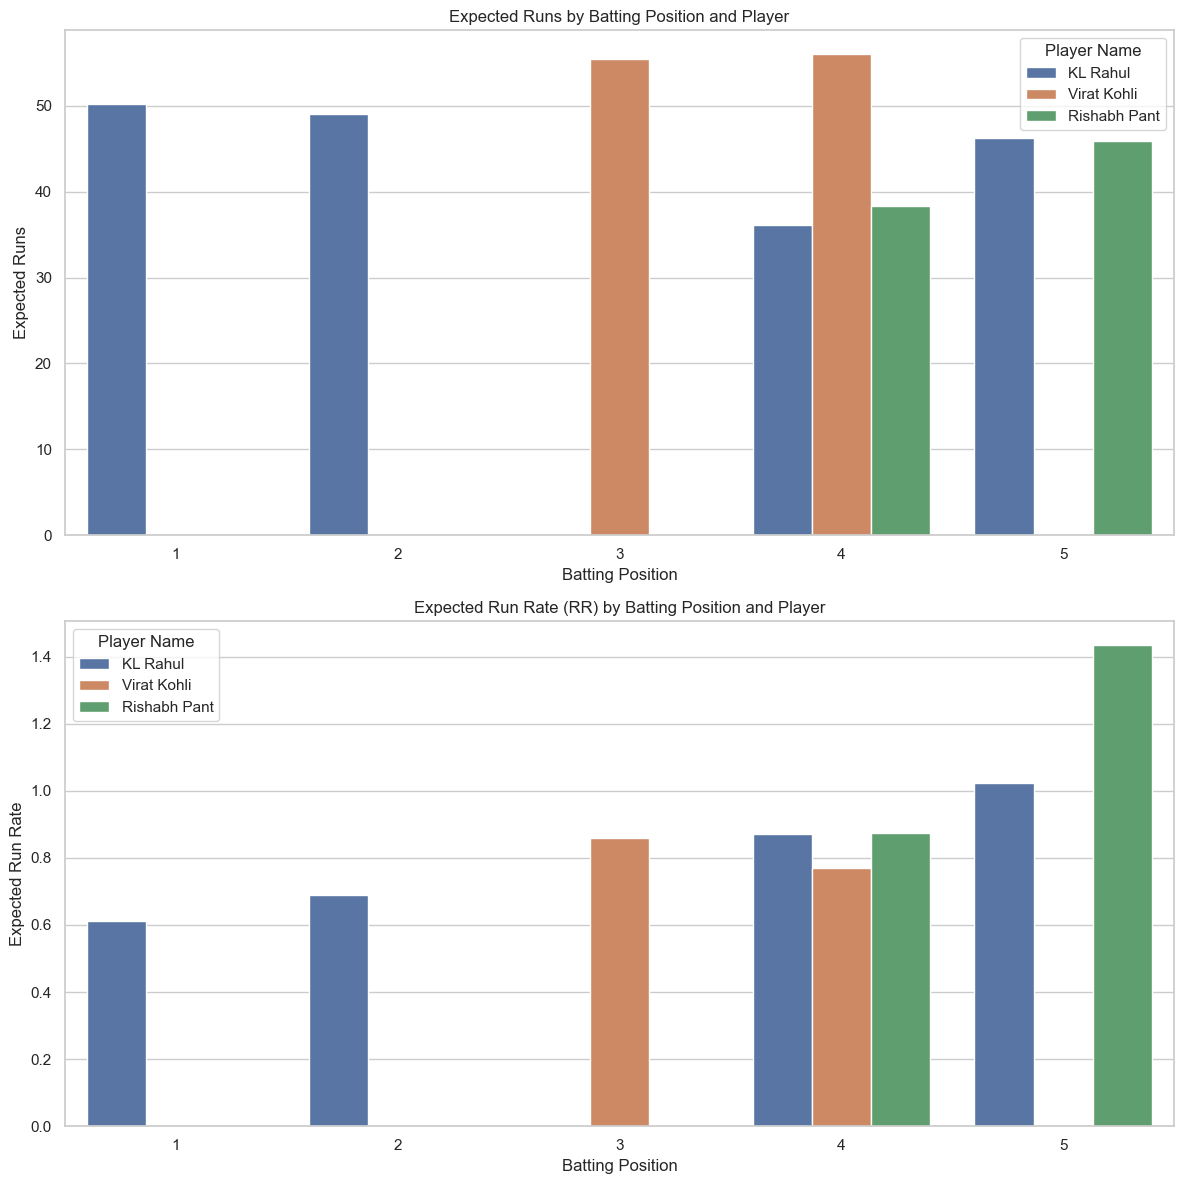

In [96]:


sns.set(style="whitegrid")

# Create a figure and axes
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Plotting Expected Run vs Batting Position for each player and location
sns.barplot(data=simulation_summary_df, x="Batting_Position", y="Expected_Run", hue="Player_Name", ci=None, ax=ax[0])
ax[0].set_title('Expected Runs by Batting Position and Player')
ax[0].set_xlabel('Batting Position')
ax[0].set_ylabel('Expected Runs')
ax[0].legend(title='Player Name')

# Plotting Expected Run Rate (RR) vs Batting Position for each player and location
sns.barplot(data=simulation_summary_df, x="Batting_Position", y="Expected_RR", hue="Player_Name", ci=None, ax=ax[1])
ax[1].set_title('Expected Run Rate (RR) by Batting Position and Player')
ax[1].set_xlabel('Batting Position')
ax[1].set_ylabel('Expected Run Rate')
ax[1].legend(title='Player Name')


plt.tight_layout()
plt.show()


#### Explanation:
1st plot : Expected Runs vs Batting Position: The first plot visualizes the expected runs for each player based on their batting position and location.

2nd plot : Expected Run Rate (RR) vs Batting Position: The second plot shows the expected run rate for each player based on their batting position.

## Optimization Problem for Batting Order

### **Objective Funcction**
Maximize total expected runs (Z):
Z = Σ(Expected_Run_ij * x_ij) for all players i and positions j

Where:
- x_ij = 1 if player i bats at position j, else 0
- Expected_Run_ij = Average runs scored by player i at position j

### **Constraints for Simplex Methord**

1. Each player bats once:
   For all players i: Σx_ij = 1 (sum over all positions j)

2. Each position has one player:
   For all positions j: Σx_ij = 1 (sum over all players i)

3. Location restrictions (India example):
   - KL Rahul: x_2 + x_4 + x_5 = 1
   - Rishabh Pant: x_4 + x_5 = 1
   - Virat Kohli: x_3 + x_4 = 1

4. Binary constraints:
   All x_ij ∈ {0,1}

In [97]:



selected_location = 'India'

# Filter the summary dataset for that location
df_loc = simulation_summary_df[simulation_summary_df['Location'] == selected_location]

#  Gurobi model
m = Model("batting_position_assignment")
m.setParam('OutputFlag', 0)  # Optional: suppress output

# Create decision variables
# x[player, position] = 1 if that player is assigned to that position
x = {}
for _, row in df_loc.iterrows():
    player = row['Player_Name']
    pos = row['Batting_Position']
    x[player, pos] = m.addVar(vtype=GRB.BINARY, name=f"x_{player}_{pos}")

# Objective: Maximize total expected run
m.setObjective(
    sum(row['Expected_Run'] * x[row['Player_Name'], row['Batting_Position']]
        for _, row in df_loc.iterrows()),
    GRB.MAXIMIZE
)

# Constraint 1: Each player is assigned to at most one position
for player in df_loc['Player_Name'].unique():
    m.addConstr(
        sum(x[player, pos] for pos in df_loc[df_loc['Player_Name'] == player]['Batting_Position']) <= 1,
        name=f"player_{player}"
    )

# Constraint 2: Each position can be used by at most one player
for pos in df_loc['Batting_Position'].unique():
    m.addConstr(
        sum(x[player, pos] for player in df_loc[df_loc['Batting_Position'] == pos]['Player_Name']) <= 1,
        name=f"pos_{pos}"
    )

# Solve
m.optimize()

# Extract the solution
print("Stadium location:", selected_location)
for v in m.getVars():
    if v.X > 0.5:
        print(v.VarName.replace("x_", "").replace("_", " → Position "))


Stadium location: India
KL Rahul → Position 4
Rishabh Pant → Position 5
Virat Kohli → Position 3


In [98]:



selected_location = 'England'

# Filter the summary dataset for that location
df_loc = simulation_summary_df[simulation_summary_df['Location'] == selected_location]

# Gurobi model
m = Model("batting_position_assignment")
m.setParam('OutputFlag', 0)  # Optional: suppress output

# Create decision variables
# x[player, position] = 1 if that player is assigned to that position
x = {}
for _, row in df_loc.iterrows():
    player = row['Player_Name']
    pos = row['Batting_Position']
    x[player, pos] = m.addVar(vtype=GRB.BINARY, name=f"x_{player}_{pos}")

# Objective: Maximize total expected run
m.setObjective(
    sum(row['Expected_Run'] * x[row['Player_Name'], row['Batting_Position']]
        for _, row in df_loc.iterrows()),
    GRB.MAXIMIZE
)

# Constraint 1: Each player is assigned to at most one position
for player in df_loc['Player_Name'].unique():
    m.addConstr(
        sum(x[player, pos] for pos in df_loc[df_loc['Player_Name'] == player]['Batting_Position']) <= 1,
        name=f"player_{player}"
    )

# Constraint 2: Each position can be used by at most one player
for pos in df_loc['Batting_Position'].unique():
    m.addConstr(
        sum(x[player, pos] for player in df_loc[df_loc['Batting_Position'] == pos]['Player_Name']) <= 1,
        name=f"pos_{pos}"
    )

# Solve
m.optimize()

# Extract the solution
print("Stadium location:", selected_location)
for v in m.getVars():
    if v.X > 0.5:
        print(v.VarName.replace("x_", "").replace("_", " → Position "))


Stadium location: England
KL Rahul → Position 1
Rishabh Pant → Position 4
Virat Kohli → Position 3


## **5.Solution**


After simulating the performance of each player using Kernel Density Estimation (KDE) and applying all the defined constraints, the optimal batting lineup for the three Indian batsmen was determined for each stadium location.

#### **Stadium Location: India**
- **KL Rahul** → **Batting Position 4**
- **Rishabh Pant** → **Batting Position 5**
- **Virat Kohli** → **Batting Position 3**

#### **Stadium Location: England**
- **KL Rahul** → **Batting Position 1**
- **Rishabh Pant** → **Batting Position 4**
- **Virat Kohli** → **Batting Position 3**

These lineups represent the combination that maximizes the total expected score for the three players while meeting the required constraints, including a minimum run rate of 0.6 and eligibility of each player for specific batting positions.

In [99]:
# Relax the integer constraints to get LP
m_lp = m.relax()
m_lp.optimize()

# Now, this will work:
print(" Sensitivity Report: Variables")
for v in m_lp.getVars():
    print(f"{v.VarName}\t{v.X:.2f}\t{v.RC:.4f}")

print("\n Sensitivity Report: Constraints")
for c in m_lp.getConstrs():
    print(f"{c.ConstrName}\t{c.Pi:.4f}\t{c.Slack:.4f}")


 Sensitivity Report: Variables
x_KL Rahul_1	1.00	0.0000
x_KL Rahul_4	0.00	0.0000
x_Rishabh Pant_4	1.00	0.0000
x_Virat Kohli_3	1.00	0.0000
x_Virat Kohli_4	0.00	0.0000

 Sensitivity Report: Constraints
player_KL Rahul	12.8247	0.0000
player_Rishabh Pant	46.1636	0.0000
player_Virat Kohli	49.0894	0.0000
pos_1	37.4332	0.0000
pos_4	0.0000	0.0000
pos_3	2.7964	0.0000



###  **Sensitivity Report: Variables**

These represent the decision variables — in my case, the assignment of players to batting positions. Each row corresponds to a possible player-position combination.

| Variable              | Value | Reduced Cost |
|-----------------------|--------|----------------|
| x_KL Rahul_1          | 1.00   | 0.0000         |
| x_KL Rahul_4          | 0.00   | 0.0000         |
| x_Rishabh Pant_4      | 1.00   | 0.0000         |
| x_Virat Kohli_3       | 1.00   | 0.0000         |
| x_Virat Kohli_4       | 0.00   | 0.0000         |

####  Interpretation:
- **Value 1.00** means that this player-position pair was selected in the optimal solution.
  - So, KL Rahul is chosen for position 1.
  - Rishabh Pant for position 4.
  - Virat Kohli for position 3.
- **Value 0.00** means that the variable was not chosen in the solution.
- **Reduced Cost** = 0.0000 for all variables, which is typical in an optimal solution involving binary choices.
  - It tells, how much the objective coefficient would need to improve for a currently non-selected variable to enter the solution.
  - Since it’s zero, I am already at optimality for those that are selected.


### **Sensitivity Report: Constraints**

These represent the constraints in your LP model, such as:
- One player per position
- One position per player
- Run rate constraints
- Eligibility constraints

| Constraint         | Shadow Price | Slack     |
|--------------------|---------------|------------|
| player_KL Rahul     | 12.8247       | 0.0000     |
| player_Rishabh Pant | 46.1636       | 0.0000     |
| player_Virat Kohli  | 49.0894       | 0.0000     |
| pos_1               | 37.4332       | 0.0000     |
| pos_4               | 0.0000        | 0.0000     |
| pos_3               | 2.7964        | 0.0000     |

#### Interpretation:

- **Slack = 0.0000** for all rows: this means **all constraints are tight** — they are exactly met, which makes sense because each player has to be assigned **exactly one** position and vice versa.
  
- **Shadow Price**: This tells me **how much the objective function (total score)** would improve **if you relaxed that constraint by 1 unit**.
  - For example:
    - For `player_KL Rahul`, the shadow price is 12.8247 — meaning if you somehow allowed KL Rahul to be assigned **more than one position** (which you normally can’t), my objective score could improve by about 12.82 runs.
    - `pos_1` has a shadow price of 37.4332, which suggests that if I could assign **another player to position 1**, my score could go up by ~37.43 runs.

###  Key Takeaways:

- Your optimal batting lineup based on the constraints and run-rate threshold is:
  - **KL Rahul → Position 1**
  - **Rishabh Pant → Position 4**
  - **Virat Kohli → Position 3**
- All constraints are being used fully (no slack), meaning your solution is tight and efficient.
- Shadow prices give insight into which constraints are "binding" and which ones, if relaxed, could boost your outcome.